In [3]:
import pandas as pd
import numpy as np
from faker import Faker

# Initialize faker
fake = Faker()

# Parameters
n_candidates = 500
stages = ["Applied", "Screen", "Assessment", "Interview", "Offer", "Join"]

data = []
for i in range(1, n_candidates+1):
    candidate_id = i
    source = np.random.choice(["LinkedIn", "Referral", "Website", "Campus"])
    education = np.random.choice(["B.Tech", "M.Tech", "MBA"])
    gpa = round(np.random.uniform(6.0, 9.5), 2)

    # simulate stage progression
    current_stage = np.random.choice(stages, p=[0.3,0.2,0.2,0.15,0.1,0.05])
    stage_date = fake.date_between(start_date="-6M", end_date="today")

    offer = 1 if current_stage in ["Offer","Join"] else 0
    joined = 1 if current_stage == "Join" else 0

    data.append([candidate_id, source, education, gpa, current_stage, stage_date, offer, joined])

df = pd.DataFrame(data, columns=["candidate_id","source","education","gpa","stage","stage_date","offer","joined"])

# Save to CSV
df.to_csv("internship_funnel.csv", index=False)

df.head()

,candidate_id,source,education,gpa,stage,stage_date,offer,joined
0,1,LinkedIn,M.Tech,7.35,Screen,2025-08-21,0,0
1,2,LinkedIn,B.Tech,7.97,Interview,2025-08-31,0,0
2,3,Referral,B.Tech,6.26,Join,2025-11-02,1,1
3,4,Referral,B.Tech,8.67,Interview,2025-09-09,0,0
4,5,Campus,M.Tech,6.15,Assessment,2025-09-20,0,0


In [2]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.0 MB/s eta 0:00:00


In [4]:
import pandas as pd

df = pd.read_csv("internship_funnel.csv")
print(df.shape)
df.head()

(500, 8)


,candidate_id,source,education,gpa,stage,stage_date,offer,joined
0,1,LinkedIn,M.Tech,7.35,Screen,2025-08-21,0,0
1,2,LinkedIn,B.Tech,7.97,Interview,2025-08-31,0,0
2,3,Referral,B.Tech,6.26,Join,2025-11-02,1,1
3,4,Referral,B.Tech,8.67,Interview,2025-09-09,0,0
4,5,Campus,M.Tech,6.15,Assessment,2025-09-20,0,0


In [5]:
# Order of stages
stages = ["Applied", "Screen", "Assessment", "Interview", "Offer", "Join"]

# Count candidates per stage
stage_counts = df["stage"].value_counts().reindex(stages).fillna(0)

# Conversion rates
conversion = stage_counts.shift(-1) / stage_counts

funnel = pd.DataFrame({
    "Stage": stages,
    "Count": stage_counts.values,
    "Conversion_to_next": conversion.values
})
funnel

,Stage,Count,Conversion_to_next
0,Applied,153,0.607843
1,Screen,93,1.064516
2,Assessment,99,0.747475
3,Interview,74,0.635135
4,Offer,47,0.723404
5,Join,34,NaN


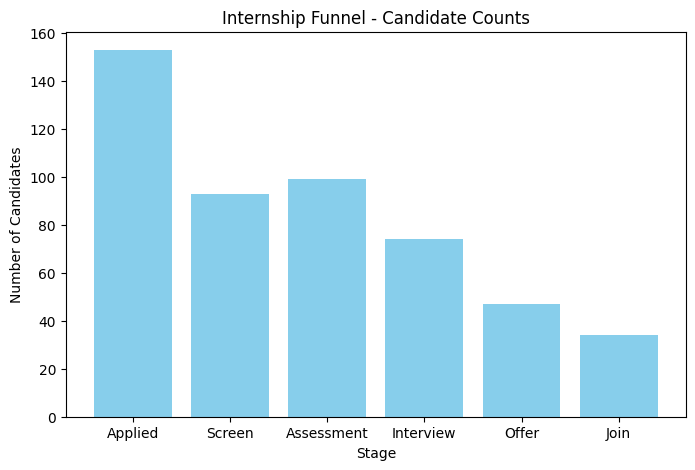

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(funnel["Stage"], funnel["Count"], color="skyblue")
plt.title("Internship Funnel - Candidate Counts")
plt.xlabel("Stage")
plt.ylabel("Number of Candidates")
plt.show()

In [7]:
source_counts = df.groupby("source")["stage"].value_counts().unstack().fillna(0)
source_counts

stage,Applied,Assessment,Interview,Join,Offer,Screen
source,,,,,,
Campus,37,33,17,8,13,25
LinkedIn,41,19,20,7,11,24
Referral,36,25,20,9,11,20
Website,39,22,17,10,12,24


In [8]:
offer_rate = df.groupby("source")["offer"].mean()
join_rate = df.groupby("source")["joined"].mean()

rates = pd.DataFrame({"Offer Rate": offer_rate, "Join Rate": join_rate})
rates

,Offer Rate,Join Rate
source,,
Campus,0.157895,0.060150
LinkedIn,0.147541,0.057377
Referral,0.165289,0.074380
Website,0.177419,0.080645


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Load dataset
df = pd.read_csv("internship_funnel.csv")

# Features and target
X = df[["source","education","gpa"]]
y_offer = df["offer"]   # target: whether candidate got an offer
y_join = df["joined"]   # target: whether candidate joined

# Preprocessing: encode categorical variables
cat_features = ["source","education"]
num_features = ["gpa"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ("num", "passthrough", num_features)
])

# Logistic regression pipeline
model_offer = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_offer, stratify=y_offer, test_size=0.2, random_state=42)

# Fit model
model_offer.fit(X_train, y_train)

# Predictions
y_pred = model_offer.predict(X_test)
y_prob = model_offer.predict_proba(X_test)[:,1]

# Evaluation
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

AUC: 0.4962797619047619
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        84
           1       0.00      0.00      0.00        16

    accuracy                           0.84       100
   macro avg       0.42      0.50      0.46       100
weighted avg       0.71      0.84      0.77       100



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
import numpy as np

# Get feature names after encoding
feature_names = model_offer.named_steps["pre"].get_feature_names_out()

# Coefficients
coef = model_offer.named_steps["clf"].coef_[0]
importance = pd.DataFrame({"Feature": feature_names, "Coefficient": coef})
importance.sort_values("Coefficient", ascending=False)

,Feature,Coefficient
5,cat__education_M.Tech,0.171918
3,cat__source_Website,0.098502
2,cat__source_Referral,0.065681
4,cat__education_B.Tech,-0.006160
0,cat__source_Campus,-0.066963
1,cat__source_LinkedIn,-0.095137
7,num__gpa,-0.114845
6,cat__education_MBA,-0.163675
